In [1]:
from typing import Dict
from typing import Union

import torch
import torch.distributions as tdist
from torch.utils.data import DataLoader


In [2]:
class ConvolvedDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        dataset_size: int,
        distribution: torch.distributions.Normal,
        input_dimension,
    ) -> None:
        self._dataset_size = dataset_size
        self._data_distribution = distribution
        self._input_dimension = input_dimension

        self._fixed_dataset = self._data_distribution.sample(
            (self._dataset_size, self._input_dimension)
        )

    def __len__(self):
        return self._dataset_size

    def __getitem__(self, idx):
        return self._fixed_dataset[idx]


    

In [5]:
import abc
from typing import Dict

import torch


class BaseData(abc.ABC):
    """Class for handling data

    Abstract methods that need to be implemented:

    - get_test_data
    - get_batch
    - signal_task_bounary_to_data_generator
    """

    def __init__(
        self, train_batch_size: int, test_batch_size: int, input_dimension: int
    ):
        """Class constructor"""
        self._train_batch_size = train_batch_size
        self._test_batch_size = test_batch_size
        self._input_dimension = input_dimension

    @abc.abstractmethod
    def get_test_data(self) -> Dict[str, torch.Tensor]:
        """returns fixed test data sets (data and labels)"""
        raise NotImplementedError("Base class method")

    @abc.abstractmethod
    def get_batch(self) -> Dict[str, torch.Tensor]:
        """returns batch of training data (input data and label if relevant)"""
        raise NotImplementedError("Base class method")


In [6]:
class ConvolvedData(BaseData):
    """Class for generating data convolved from multiple distributions."""

    def __init__(
        self,
        train_batch_size: int,
        test_batch_size: int,
        input_dimension: int,
        mean: Union[int, float],
        variance: Union[int, float],
        dataset_size: Union[str, int],
    ):
        super().__init__(
            train_batch_size=train_batch_size,
            test_batch_size=test_batch_size,
            input_dimension=input_dimension,
        )

        self._data_distribution = tdist.Normal(mean, variance)

        self._dataset_size = dataset_size

    def get_test_data(self) -> Dict[str, torch.Tensor]:
        """Give fixed test data set (input data only)."""
        test_input_data = self._data_distribution.sample(
            (self._test_batch_size, self._input_dimension)
        )

        test_data_dict = {"x": test_input_data}

        return test_data_dict

    def get_batch(self) -> Dict[str, torch.Tensor]:
        """Returns batch of training data (input only)"""
        batch = self._get_infinite_dataset_batch()
        return {"x": batch}

    def _get_finite_dataset_batch(self) -> torch.Tensor:
        try:
            batch = next(iter(self._data_iterator))
        except StopIteration:
            self._reset_data_iterator()
            batch = next(iter(self._data_iterator))
        return batch

    def _get_infinite_dataset_batch(self) -> torch.Tensor:
        #This is where we need to change the code
        batch = self._data_distribution.sample(
            (self._train_batch_size, self._input_dimension)
        )
        return batch

    def _reset_data_iterator(self):
        self._dataloader = DataLoader(
            self._dataset, batch_size=self._train_batch_size, shuffle=True
        )
        self._data_iterator = iter(self._dataloader)

In [3]:
dist = tdist.Normal(0, 1)
batch = dist.sample((2, 10))
print(batch)

tensor([[ 1.0535, -0.3791, -0.5424, -1.0070, -0.3646,  0.9901, -0.6188, -1.3972,
          1.7966, -0.6065],
        [-0.0409, -0.7957,  0.0602, -0.1212,  0.6674, -0.0731,  0.5931,  0.1556,
          0.1339,  0.3766]])


In [14]:
dist = tdist.Uniform(0, 1)
batch = dist.sample((2, 10))
print(batch)

tensor([[0.5913, 0.0294, 0.4440, 0.0527, 0.4132, 0.3991, 0.7649, 0.4243, 0.8228,
         0.4196],
        [0.4653, 0.9533, 0.4380, 0.4892, 0.4921, 0.2982, 0.5418, 0.6130, 0.5040,
         0.2041]])


In [20]:
import numpy as np
print(np.arange(1, 10, 1))

[1 2 3 4 5 6 7 8 9]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
import scipy as sp
import scipy.special
import random
import torch
def convolve_exp_norm(gamma, sigma, x, mu=0, tau=0):
    """
    Parameters:
    gamma = index of exponential
    mu = mean of the Gaussian (i.e. the centroid). If none-zero it is an offset
    sigma = std of normal distribution
    x = input value
    tau = pdf offset


    """
    co = (gamma/2.0) * np.exp( gamma*mu+ gamma*gamma*sigma*sigma/2.0)
    x_erf = (mu + gamma*sigma*sigma - x - tau)/(np.sqrt(2.0)*sigma)
    y = co * np.exp(-gamma*(x + tau)) * (1.0 - scipy.special.erf(x_erf))
    return y


In [11]:
convolve_exp_norm(1, 2, 0.5)

0.17953268548352722

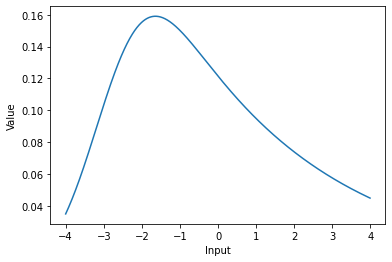

In [12]:
n = np.arange(-4, 4, 0.01)
y = [convolve_exp_norm(0.25, 1, _, -3, 0) for _ in n]

plt.plot(n, y)
#plt.grid()
plt.ylabel('Value')
plt.xlabel('Input')
plt.show()

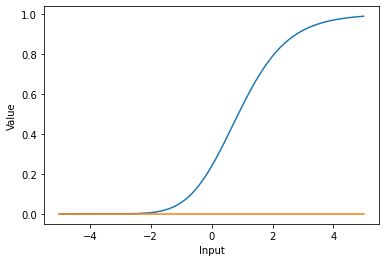

In [14]:
import scipy.integrate as integrate
import scipy.special as special
from pynverse import inversefunc

def convolved_cdf(p):
    result = integrate.quad(lambda x: convolve_exp_norm(1, 1, x), -5, p)
    return result

n = np.arange(-5, 5, 0.01)
y = [convolved_cdf(_) for _ in n]
plt.plot(n, y)
#plt.grid()
plt.ylabel('Value')
plt.xlabel('Input')
plt.show()

No handles with labels found to put in legend.


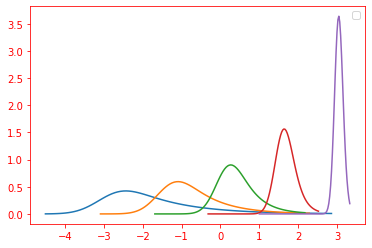

In [70]:
from scipy.stats import exponnorm

k = np.linspace(2.5,0,5, endpoint=False)
mean = np.linspace(-3,3,5)
std = np.linspace(0.5, 0, 5, endpoint = False)
x = [np.linspace(exponnorm.ppf(0.01,i,loc = j, scale = 1), exponnorm.ppf(0.99, i, loc = j, scale = z), 100) for i,j,z in zip(k, mean, std)]
y = [exponnorm(i, loc = j, scale = z).rvs(size=1000) for i,j,z in  zip(k,mean, std)]
fig, ax = plt.subplots(1, 1)
for _ in range(len(y)):
    plt.plot(x[_], exponnorm.pdf(x[_],k[_], loc = mean[_], scale =std[_] ))

ax.spines['bottom'].set_color('red')
ax.spines['top'].set_color('red') 
ax.spines['right'].set_color('red')
ax.spines['left'].set_color('red')
ax.tick_params(axis='x', colors='red', which = 'both')
ax.tick_params(axis='y', colors='red', which = 'both')
plt.legend()
plt.show()

In [113]:
from scipy.stats import exponnorm
import time

start = time.time()
rv = exponnorm(0.5)
y = 1000
z = 500
x = [rv.rvs(size=y) for i in range(z)]

x = torch.FloatTensor(np.array(x)) 
x = x.apply_(lambda z: z*10)
end = time.time()
print(end-start)


0.07068061828613281
